In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import matplotlib.cm as cm
    
import sys 
sys.path.insert(0, '../src/')

from astropy.table import Table
import galhalo
import anaclass
import os
import warnings; warnings.simplefilter('ignore')
import mcmc_aux
from collections import Counter


In [25]:
toy = np.random.randint(12, size=(100,100))

In [26]:
def subtle_sort(array):
    return array[np.flip(np.lexsort(np.transpose(array)[::-1]))]

def MASS_RANK(lgMs_2D, min_mass=6.5, plot=False):
    if plot == True:
        plt.imshow(lgMs_2D)

    lgMs_2D = np.nan_to_num(lgMs_2D)

    lgMs_2D = np.flip(np.sort(lgMs_2D, axis=1), axis=1) # sort in ascending order for each host!

    N_gt = np.sum(lgMs_2D > min_mass, axis=1) # count for each host, how many are greater than the min
    sort = np.flip(np.argsort(N_gt)) # sort based on N_gt
    max_N = np.max(N_gt)

    N_gt = N_gt[sort] # no sort and cut
    lgMs_2D = lgMs_2D[sort][:,0:max_N] 

    if plot == True:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(5, 10))
        ax1.imshow(lgMs_2D)
        ax2.imshow(np.expand_dims(N_gt, axis=1))

    N_ties = Counter(N_gt) # to count how many ties we have across hosts!
    #keys = np.array(list(N_ties.keys()))
    occcurances = np.array(list(N_ties.values()))

    split = np.split(lgMs_2D, np.cumsum(occcurances))[0:-1] # break into chunks to sort each tie

    full = []
    for i, value in enumerate(occcurances):
        if value == 1: # no ties so just pass as is
            full.append(split[i])
        else: # sort each tie chunk
            full.append(subtle_sort(split[i]))

    full = np.concatenate(full) # stitch back together (original shape)

    if plot==True:
        N_gt = np.sum(full > min_mass, axis=1)
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(5, 10))
        ax1.imshow(full)
        ax2.imshow(np.expand_dims(N_gt, axis=1))

    #padN =20 - max_N
    #full = np.pad(full, [(0, 0), (0, padN)], constant_values=0)
    return full

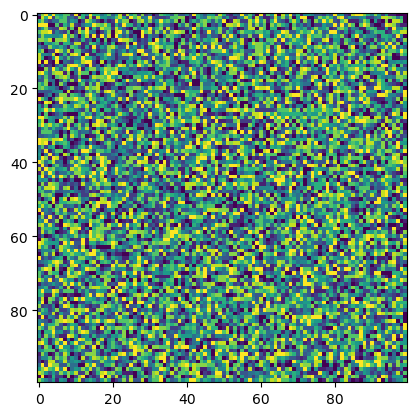

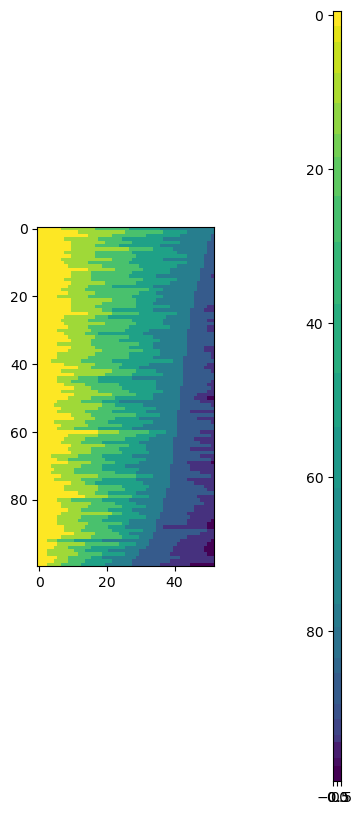

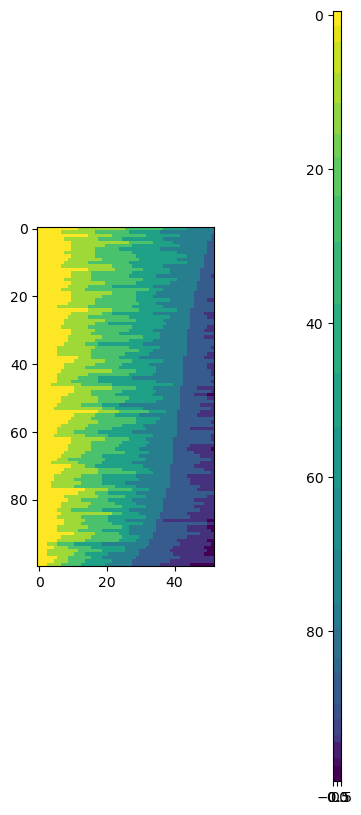

In [27]:
hmm = MASS_RANK(toy, plot=True)

In [8]:
hmm

array([[11, 10, 10, ...,  0,  0,  0],
       [10, 10, 10, ...,  0,  0,  0],
       [11, 11, 11, ...,  0,  0,  0],
       ...,
       [10,  5,  5, ...,  0,  0,  0],
       [ 9,  6,  6, ...,  0,  0,  0],
       [ 7,  6,  6, ...,  0,  0,  0]])

In [9]:
data = mcmc_aux.prep_run("../../data/3000_12_8/")

data.create_SAGA_samples()


dividing your sample into 30 sets
chose ID 9 as the random sample to use as the real data!


## this is just for one of the L samples! need to expand this!

In [10]:
wow = galhalo.master_SHMR_2D(data.lgMh_real, N_samples=10)

In [11]:
hmm = MASS_RANK(wow[:,5,:])

In [12]:
test = np.zeros(shape=(wow.shape[1], wow.shape[0], 20))

for i in range(wow.shape[1]):

    test[i] = MASS_RANK(wow[:,i,:])

In [14]:
test.shape

data_test = np.average(test, axis=0)

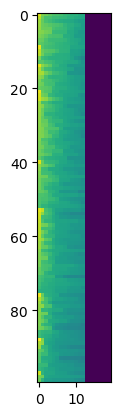

In [19]:
plt.imshow(test[7])

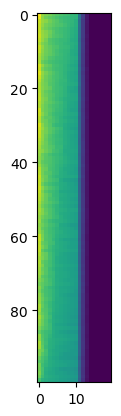

In [15]:
plt.imshow(data_test)

In [ ]:
def CSMF(lgMs):

    mass_bins = np.linspace(4,11,45)
    counts = np.apply_along_axis(anaclass.cumulative, 1, lgMs) 

    quant = np.percentile(counts, np.array([5, 50, 95]), axis=0, method="closest_observation")
    
    plt.figure(figsize=(8, 8))
    plt.plot(mass_bins, quant[1], label="median", color="black")
    plt.fill_between(mass_bins, y1=quant[0], y2=quant[2], alpha=0.2, color="grey", label="5% - 95%")
    plt.yscale("log")
    plt.grid(alpha=0.4)
    plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
    plt.ylabel("log N (> m$_{stellar}$)", fontsize=15)
    plt.legend()
    plt.show()

    return quant # the stats across realizations